In [12]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla P100-PCIE-16GB


In [13]:
train_dir = "/kaggle/input/stanfordcarswithclasses/Stanford2015_with_classes/car_data/car_data/train"
test_dir = "/kaggle/input/stanfordcarswithclasses/Stanford2015_with_classes/car_data/car_data/test"

train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder(root=train_dir, transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=test_dir, transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 2)

In [14]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [18]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

# ResNet34

In [20]:
model_ft_resnet34 = models.resnet34(pretrained=True)
num_ftrs_resnet34 = model_ft_resnet34.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
num_ftrs_resnet34 = model_ft_resnet34.fc.in_features
model_ft_resnet34.fc = nn.Linear(num_ftrs_resnet34, 196)
model_ft_resnet34 = model_ft_resnet34.to(device)

n_epochs=10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft_resnet34.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

model_ft_resnet34, training_losses_resnet34, training_accs_resnet34, test_accs_resnet34 = train_model(
    model_ft_resnet34, criterion, optimizer, lrscheduler, n_epochs=n_epochs)

Epoch 1, duration: 74 s, loss: 3.9709, acc: 15.7475
Accuracy of the network on the test images: 36 %
Epoch 2, duration: 74 s, loss: 1.6856, acc: 55.5147
Accuracy of the network on the test images: 63 %
Epoch 3, duration: 74 s, loss: 0.8935, acc: 75.6618
Accuracy of the network on the test images: 67 %
Epoch 4, duration: 74 s, loss: 0.5529, acc: 84.7794
Accuracy of the network on the test images: 77 %
Epoch 5, duration: 74 s, loss: 0.3509, acc: 90.6985
Accuracy of the network on the test images: 75 %
Epoch 6, duration: 74 s, loss: 0.2551, acc: 92.9167
Accuracy of the network on the test images: 81 %
Epoch 7, duration: 73 s, loss: 0.1763, acc: 95.0735
Accuracy of the network on the test images: 79 %
Epoch 8, duration: 73 s, loss: 0.1376, acc: 96.4216
Accuracy of the network on the test images: 85 %
Epoch 9, duration: 74 s, loss: 0.0628, acc: 98.6397
Accuracy of the network on the test images: 90 %
Epoch 10, duration: 74 s, loss: 0.0427, acc: 99.0686
Accuracy of the network on the test im

In [22]:
# test accuracy of ResNet34
test_accs_resnet34

[36.73672428802388,
 63.58661857977864,
 67.61596816316379,
 77.95050366869792,
 75.53786842432534,
 81.6440741201343,
 79.67914438502673,
 85.90971272229822,
 90.32458649421714,
 90.44894913567964]

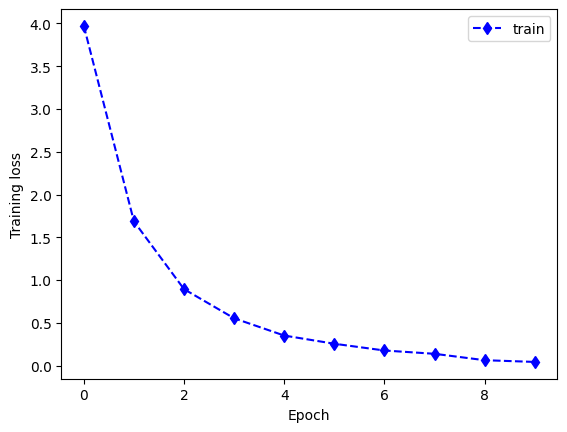

In [24]:
def plot_loss(training_losses, model_name):
    fig, ax = plt.subplots()
    ax.plot(training_losses, 'bd', linestyle='--', label='train')
#     ax.set_title("Train and test accuracies")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training loss')
    ax.legend()
    fig.savefig(f'fig_{model_name}_training_losses.pdf')
plot_loss(training_losses_resnet34, 'ResNet34')

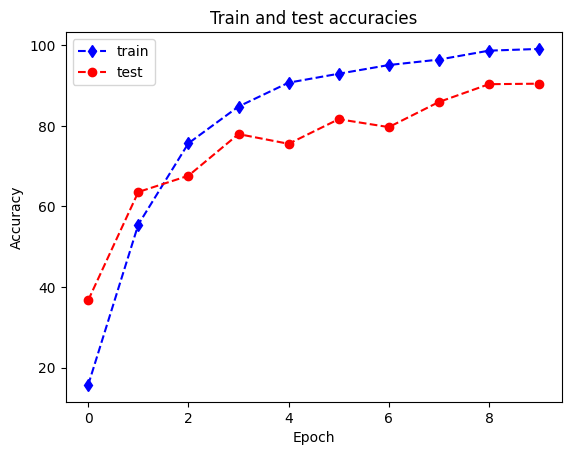

In [26]:
def plot_train_test_accuracies(training_accs, test_accs, model_name):
    fig, ax = plt.subplots()
    ax.plot(training_accs, 'bd', linestyle='--', label='train')
    ax.plot(test_accs, 'ro', linestyle='--', label='test')
    ax.set_title("Train and test accuracies")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    fig.savefig(f'fig_{model_name}_train_test_accuracies.pdf')

plot_train_test_accuracies(training_accs_resnet34, test_accs_resnet34, 'ResNet34')

# ResNet50

In [31]:
model_ft_resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs_resnet50 = model_ft_resnet50.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
num_ftrs_resnet50 = model_ft_resnet50.fc.in_features
model_ft_resnet50.fc = nn.Linear(num_ftrs_resnet50, 196)
model_ft_resnet50 = model_ft_resnet50.to(device)

n_epochs=10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft_resnet50.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

model_ft_resnet50, training_losses_resnet50, training_accs_resnet50, test_accs_resnet50 = train_model(
    model_ft_resnet50, criterion, optimizer, lrscheduler, n_epochs=n_epochs)

Epoch 1, duration: 135 s, loss: 4.0732, acc: 14.7917
Accuracy of the network on the test images: 34 %
Epoch 2, duration: 135 s, loss: 1.7301, acc: 55.0000
Accuracy of the network on the test images: 60 %
Epoch 3, duration: 135 s, loss: 0.9359, acc: 75.5515
Accuracy of the network on the test images: 68 %
Epoch 4, duration: 135 s, loss: 0.5983, acc: 83.0882
Accuracy of the network on the test images: 73 %
Epoch 5, duration: 135 s, loss: 0.3999, acc: 88.9828
Accuracy of the network on the test images: 80 %
Epoch 6, duration: 135 s, loss: 0.2830, acc: 92.4020
Accuracy of the network on the test images: 83 %
Epoch 7, duration: 135 s, loss: 0.2017, acc: 94.5956
Accuracy of the network on the test images: 85 %
Epoch 8, duration: 135 s, loss: 0.0991, acc: 97.8676
Accuracy of the network on the test images: 91 %
Epoch 9, duration: 135 s, loss: 0.0651, acc: 98.6887
Accuracy of the network on the test images: 91 %
Epoch 10, duration: 135 s, loss: 0.0538, acc: 98.9706
Accuracy of the network on t

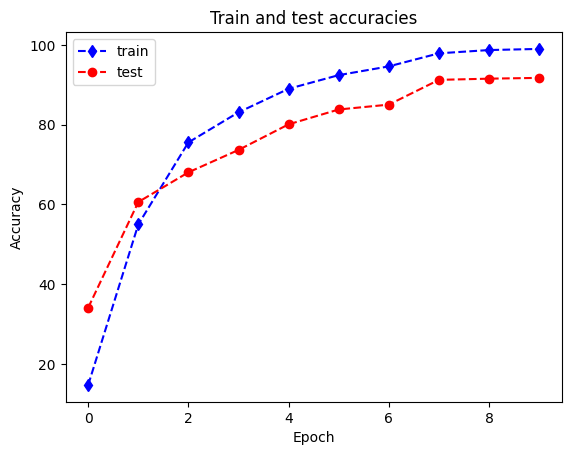

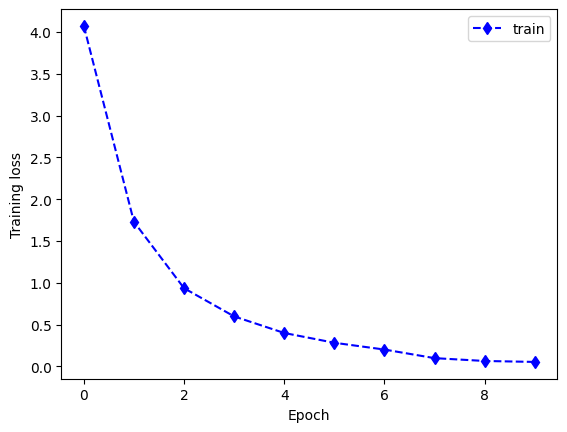

In [32]:
plot_train_test_accuracies(training_accs_resnet50, test_accs_resnet50, 'ResNet50')
plot_loss(training_losses_resnet50, 'ResNet50')